# Olist E-Commerce Analysis 

The Olist e-commerce Analysis is a notebook dedicated to analise and extract insights from a public dataset of a Brazilian e-commerce. The dataset has information of 100k orders from 2016 to 2018 made at multiple marketplaces in Brazil. The analysis are oriented in two main topics, sales and logistics. 

## Index
1. **Dataset and data structure**
2. **Importing libraries**
3. **Importing data**
4. **Exploring the dataset**  
    4.1 Analysis by state   
    4.2 Analysis by product category     
5. **Temporal analysis**   
    5.1 Monthly revenue   
    5.2 Monthly top selling categories    
6. **Logistics**    
    6.1 Relation between delivery time and revenue    
    6.2 Delivery performance   
    6.2 Delivery performance by state      
    6.3 Delivery performance by product category     
    6.5 Steps of the delivery process   
    

***

## 1. Dataset and data structure

We utilized the [Brazilian E-Commerce Public Dataset by Olist](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce) for the analysis. The dataset has information of 100k orders from 2016 and 2018 with orders made at [Olist e-commerce](https://olist.com), the largest department store in Brazil. The data is structured in 8 tables as shown below. 

#### Data structure  
Tables
* `customers`
* `geolocation`
* `order_items`
* `order_payments`
* `order_reviews`
* `orders`
* `products`
* `sellers`
* `product_category_name_translation`

#### The tables connections are shown in this schema:

<img src="olist_db.png" alt="Drawing" align="left" style="width: 600px;"/>

***

## 2. Importing libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import textwrap as tw 

***

## 3. Importing data

In [2]:
customers = pd.read_csv('./data/olist_customers_dataset.csv')
geolocation = pd.read_csv('./data/olist_geolocation_dataset.csv')
order_items = pd.read_csv('./data/olist_order_items_dataset.csv')
order_payments = pd.read_csv('./data/olist_order_payments_dataset.csv')
order_reviews = pd.read_csv('./data/olist_order_reviews_dataset.csv')
orders = pd.read_csv('./data/olist_orders_dataset.csv')
products = pd.read_csv('./data/olist_products_dataset.csv')
sellers = pd.read_csv('./data/olist_sellers_dataset.csv')
product_category_translation = pd.read_csv('./data/product_category_name_translation.csv')

***

## 4. Exploring the dataset

In this starting phase, we will try to answer some basic questions:
- Is there any relation between the Average Ticket Price and Revenue?
- Is the revenue distributed evenly across the states?
- How does de Average Ticket Price (ATP) change from state to state?
- Which are the top selling product categories?
  

### 4.1 Analysis by state

In [3]:
# Joining tables
df = customers.merge(orders, on=['customer_id'])
df = df[['order_id', 'customer_state', 'customer_city']]
df = df.merge(order_items, on=['order_id'])
df = df[['customer_state', 'price']]

# Counting orders
df['total_orders'] = 1

# Agrupando as colunas por estado
df = df.groupby('customer_state').sum().sort_values(by=['price'],ascending=False)

# Adding a column to calculate the average ticket price (atp)
df['atp'] = df['price']/df['total_orders']

df['%revenue'] = df['price']*100/df['price'].sum()

sales_state = df
sales_state.head()

,price,total_orders,atp,%revenue
customer_state,,,,
SP,5202955.05,47449,109.653629,38.280543
RJ,1824092.67,14579,125.117818,13.420692
MG,1585308.03,13129,120.748574,11.663843
RS,750304.02,6235,120.337453,5.520333
PR,683083.76,5740,119.004139,5.025763


note: in this notebook we are calculating de Average Ticket Price of each order. 

In [4]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df.describe()

,price,total_orders,atp,%revenue
count,27.00,27.00,27.00,27.00
mean,503394.21,4172.22,145.17,3.70
std,1040224.19,9399.10,21.14,7.65
min,7829.43,52.00,109.65,0.06
25%,69617.83,414.50,125.44,0.51
50%,156453.53,1055.00,145.51,1.15
75%,406976.96,3102.50,158.94,2.99
max,5202955.05,47449.00,191.48,38.28


When we compare the inicial rows in the `head()` table with the overview shown in the `describe()` table, we can make some points:
- The mean is very different from the median (50%) which indicates that we have very different values in the dataset
- We can confirm this by looking to the max and min value. 
- An interesting observation is that the atp (Average Ticket Price) is lower where the revenue is higher

Let's plot some graphs to see this in detail   
   

#### Plotting graphs

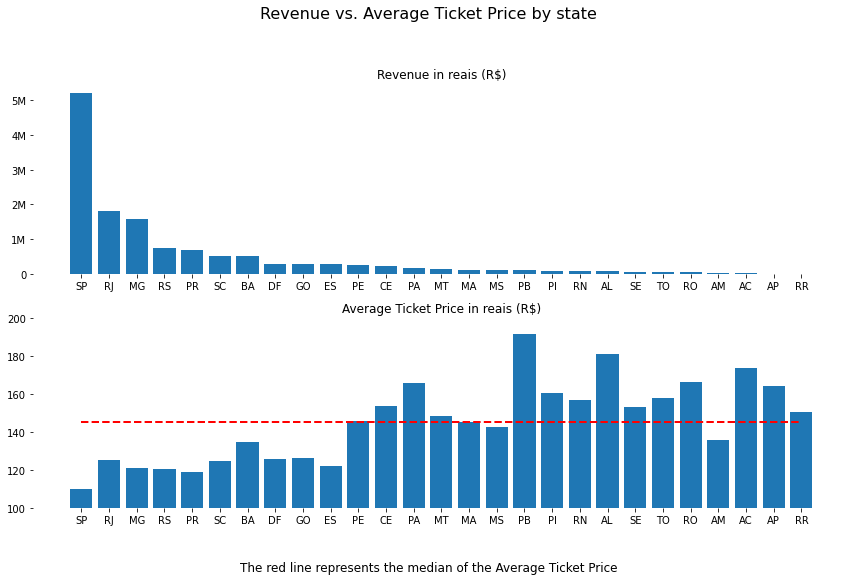

In [8]:
plt.figure(figsize=(12,7))
plt.suptitle(f"Revenue vs. Average Ticket Price by state", y=1.05, fontsize=16)

plt.subplot(211)
plt.bar(sales_state.index, sales_state['price'])
plt.title('Revenue in reais (R$)')
plt.yticks([0,1e+6,2e+6,3e+6,4e+6,5e+6], labels=['0', '1M', '2M', '3M', '4M', '5M'])
plt.box(False)

plt.subplot(212)
plt.bar(sales_state.index, sales_state['atp'])
plt.title('Average Ticket Price in reais (R$)')
plt.ylim(100,200)
plt.yticks([100,120,140,160,180,200])
plt.hlines(y = 145,xmin=0, xmax='RR', colors='red', linestyle='dashed', linewidth=2)

footnote = f"The red line represents the median of the Average Ticket Price"
fig_txt = tw.fill(tw.dedent(footnote.rstrip()), width=150)
plt.figtext(0.5, -0.07, fig_txt, horizontalalignment='center', fontsize=12, multialignment="left")

plt.tight_layout()
plt.box(False)
plt.show()

#### Conclusions
- More than 60% of the revenue is concentrated in the Southeast region of Brazil (SP, RG, MG)
- Sao Paulo is an outlier
- In the top revenue states, the Average Ticket Price tends to be lower


*** 

### 4.2 Analysis by product category

#### Preparing the data

In [5]:
# order_items -- (product_id) -- products
df = order_items.merge(products, on=['product_id'])[['product_category_name', 'price']]
df = df.merge(product_category_translation, on=['product_category_name'])[['product_category_name_english', 'price']]

df['total_orders'] = 1
df = df.groupby('product_category_name_english').sum().sort_values(by=['price'],ascending=False)

# Adding a column to calculate the average ticket price (atp)
df['ticket_medio'] = df['price']/df['total_orders']

df['%revenue'] = df['price']*100/df['price'].sum()

category_sum = df
category_sum.head()

,price,total_orders,ticket_medio,%revenue
product_category_name_english,,,,
health_beauty,1258681.34,9670,130.163531,9.388524
watches_gifts,1205005.68,5991,201.135984,8.988157
bed_bath_table,1036988.68,11115,93.296327,7.734915
sports_leisure,988048.97,8641,114.344285,7.369873
computers_accessories,911954.32,7827,116.513903,6.802282


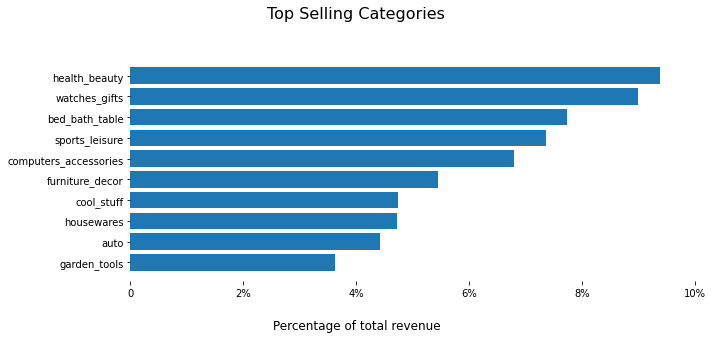

In [6]:
# filtering the top 10 categories in revenue
category_sum = category_sum[:10]
values = category_sum['%revenue']

# Ordering by revenue
df = pd.DataFrame({'categories' : category_sum.index, 'values' : values,})
df_sorted = df.sort_values('values',ascending=True)

plt.figure(figsize=(10,4))
plt.suptitle(f'Top Selling Categories', y=1.05, fontsize=16)
footnote = f"Percentage of total revenue"

plt.barh('categories', 'values', data=df_sorted)
plt.xticks([0, 2, 4, 6, 8, 10], labels=['0', '2%', '4%', '6%', '8%', '10%'])

fig_txt = tw.fill(tw.dedent(footnote.rstrip()), width=150)
plt.figtext(0.5, -0.07, fig_txt, horizontalalignment='center', fontsize=12, multialignment="left")

plt.box(False)
plt.tight_layout()
plt.show()

***

## 5. Temporal Analysis

#### Preparing the data

In [8]:
# customers -- (customer_id) -- orders
df = customers.merge(orders, on=['customer_id'])
df = df[['order_id', 'customer_state', 'order_approved_at']]

# orders -- (order_id) -- order_items
df = df.merge(order_items, on=['order_id'])
df = df[['customer_state', 'order_approved_at','price', 'product_id']]

# order_items -- (product_id) -- products
df = df.merge(products, on=['product_id'])
df = df[['customer_state', 'price', 'order_approved_at', 'product_category_name']]

df = df.merge(product_category_translation, on=['product_category_name'])
df = df[['customer_state', 'price', 'order_approved_at','product_category_name_english']]

#### Adding a some date columns

In [9]:
df['date'] = pd.to_datetime(df['order_approved_at'], format="%Y-%m-%d").dt.strftime('%Y/%m')
df['day'] = pd.to_datetime(df['order_approved_at'], format="%Y-%m-%d").dt.strftime('%d')

sales_df = df

***

### 5.1 Monthly Revenue

In [10]:
df = sales_df
df = df.groupby('date').sum()

# dropping some data
df = df.drop(df.index[0:3])
df = df.drop(df.tail(1).index)

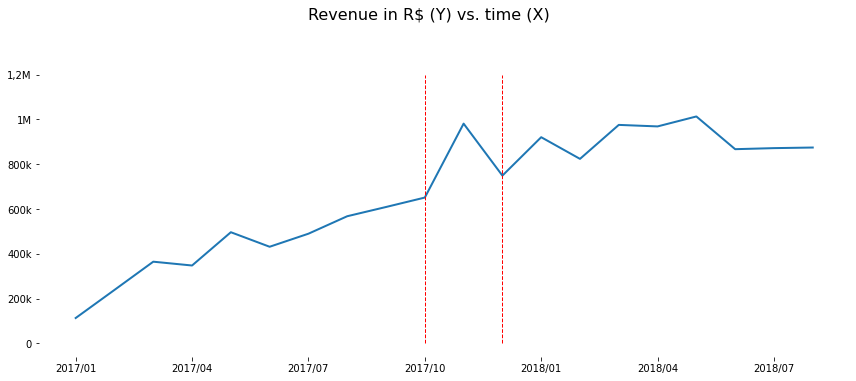

In [11]:
plt.figure(figsize=(12,5))
plt.suptitle(f'Revenue in R$ (Y) vs. time (X)', y=1.05, fontsize=16)

plt.plot(df.index, df.price, linewidth=2)
plt.xticks(df.index[::3].tolist())
plt.yticks([0, 2e+5, 4e+5, 6e+5, 8e+5, 10e+5, 12e+5], labels=['0','200k','400k','600k','800k', '1M', '1,2M'])

plt.vlines(x = '2017/10', ymin=0, ymax=1200000, colors='red', linestyle='dashed', linewidth=1)
plt.vlines(x = '2017/12', ymin=0, ymax=1200000, colors='red', linestyle='dashed', linewidth=1)

plt.box(False)
plt.tight_layout()
plt.show()

From 2017 to 2018 we had some fluctuations in sales, the most expressive occurred in November 2017.    
Now we're going to analise this month in detail.

#### Detailing November 2017

In [12]:
df = sales_df

df = df.loc[df['date'] == '2017/11']
df = df.groupby('day').sum()

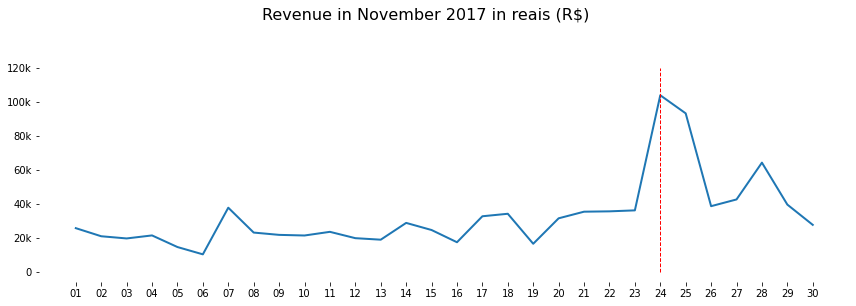

In [13]:
plt.figure(figsize=(12,4))
plt.suptitle(f'Revenue in November 2017 in reais (R$) ', y=1.05, fontsize=16)

plt.plot(df.index, df.price, linewidth=2)
plt.yticks([0, 2e+4, 4e+4, 6e+4, 8e+4, 10e+4, 12e+4], labels=['0','20k','40k','60k','80k', '100k', '120k'])

plt.vlines(x = '24', ymin=0, ymax=120000, colors='red', linestyle='dashed', linewidth=1)

plt.box(False)
plt.tight_layout()
plt.show()

Analising November 2017 in detail we can see a huge peak in November 24th an 25th. Searching for external events in this date we found out that this was the date of **Black Friday**.


***

## 5.2 Monthly top selling categories   

#### Preparing the data

In [14]:
df = sales_df
df = df.groupby(['product_category_name_english','date']).sum()

# converting the table
df = df.pivot_table(index='date', columns='product_category_name_english', values='price')

# excluindo dados fora do intervalo
df = df.drop(df.index[0:3])
df = df.drop(df.tail(1).index)

df.describe()

product_category_name_english,agro_industry_and_commerce,air_conditioning,art,arts_and_craftmanship,audio,auto,baby,bed_bath_table,books_general_interest,books_imported,...,security_and_services,signaling_and_security,small_appliances,small_appliances_home_oven_and_coffee,sports_leisure,stationery,tablets_printing_image,telephony,toys,watches_gifts
count,19.000000,20.000000,17.000000,6.000000,19.000000,20.000000,20.000000,20.00000,20.000000,15.000000,...,2.000000,18.000000,20.000000,11.000000,20.000000,20.000000,17.000000,20.0000,20.000000,20.000000
mean,3817.393158,2665.893500,1423.684706,302.335000,2659.553158,29544.343000,20506.736500,51818.78500,2336.869000,309.323333,...,141.645000,1194.957222,9516.934000,4313.246364,49232.317500,11547.161500,442.847647,16150.4975,23974.075500,60082.272000
std,3500.605051,1217.198962,1745.692363,379.175832,2384.015144,14212.534332,12863.337707,22235.42273,1633.350693,199.153693,...,58.894924,1452.424074,4994.634596,4554.416985,21773.224112,9223.390185,435.165085,9043.2335,14636.240836,32929.231947
min,65.970000,663.700000,75.000000,15.990000,163.800000,5126.430000,3363.470000,3780.36000,234.890000,19.990000,...,100.000000,75.000000,1461.790000,71.900000,9602.640000,1561.990000,49.900000,2945.8600,4747.100000,8086.520000
25%,1285.000000,1996.122500,349.050000,38.942500,1092.735000,15199.655000,9379.565000,34792.14250,1188.160000,165.000000,...,120.822500,461.347500,6001.655000,505.490000,36016.445000,5941.165000,161.800000,8811.2275,15534.827500,34277.102500
50%,3376.650000,2649.995000,461.500000,109.850000,2069.400000,32595.810000,21088.230000,56320.26500,1926.365000,317.990000,...,141.645000,729.895000,9173.030000,3024.900000,49576.765000,9999.555000,350.400000,14396.6850,21566.290000,64216.915000
75%,5366.570000,3559.650000,1895.500000,523.402500,2828.955000,42923.917500,26067.402500,69357.98250,2821.145000,409.600000,...,162.467500,1017.067500,11431.147500,6005.785000,62031.405000,14127.717500,594.000000,22696.6925,25347.530000,91337.602500
max,13932.490000,4620.940000,7087.550000,901.760000,9561.600000,48848.140000,49253.580000,87884.28000,6315.460000,749.000000,...,183.290000,5863.180000,23160.980000,12410.600000,90019.490000,41350.910000,1811.980000,38486.7600,60978.490000,122011.380000


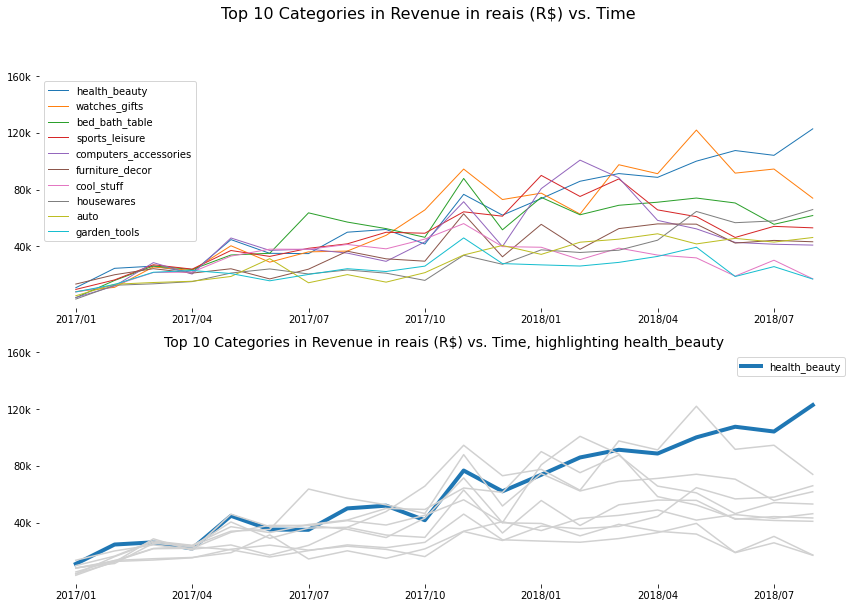

In [34]:
top_categories = ['health_beauty', 'watches_gifts', 'bed_bath_table', 'sports_leisure',
       'computers_accessories', 'furniture_decor', 'cool_stuff', 'housewares',
       'auto', 'garden_tools']

plt.figure(figsize=(12, 8))
plt.suptitle(f'Top 10 Categories in Revenue in reais (R$) vs. Time', y=1.05, fontsize=16)

plt.subplot(211) 
for category in top_categories:
    plt.plot(df.index, df[category], label=category, linewidth=1)

plt.xticks(df.index[::3].tolist())
plt.yticks([40000, 80000, 120000, 160000], labels =['40k', '80k', '120k', '160k'])
plt.box(False)
plt.legend()   

plt.subplot(212)
for category in top_categories:
    if category not in ['health_beauty']:
        plt.plot(df.index, df[category],  color='#D1D1D1')
    else:
        plt.plot(df.index, df[category], label=category, linewidth=4)
    
    
plt.title('Top 10 Categories in Revenue in reais (R$) vs. Time, highlighting health_beauty', fontdict={'fontsize':14})
plt.xticks(df.index[::3].tolist())
plt.yticks([40000, 80000, 120000, 160000], labels =['40k', '80k', '120k', '160k'])
plt.legend()

plt.tight_layout()
plt.box(False)
plt.show()

Analising the evolution in time of the top 10 categories, one category `health_beauty` really draws attention. While most product categories growth were very instable, `health_beauty` monthly growth was positive in almost all periods. 

***

## 6. Logistics

In this section we will analise the data from deliveries and try to answer the following questions:
- What's the percentage of delays?
- Is there any relation between the delivery time and revenue from state to state?
- Is there any state in which the percentage of delays are higher?
- Which part of the delivery process is more responsible for the delays?

In [7]:
# order_items -- (product_id) -- products
df = order_items.merge(products, on=['product_id'])[['order_id', 'product_category_name', 'price']]

df = df.merge(product_category_translation, on=['product_category_name'])
df = df[['order_id','product_category_name_english', 'price']]

# order_items -- (order_id) -- orders
df = df.merge(orders, on=['order_id'])

df = df[['product_category_name_english','price', 'order_approved_at', 'order_delivered_carrier_date',
         'order_delivered_customer_date', 'order_estimated_delivery_date', 'customer_id']]

# # customers -- (customer_id) -- orders
df = df.merge(customers, on=['customer_id'])

df = df[['product_category_name_english', 'customer_state','price','order_approved_at','order_delivered_carrier_date',
         'order_delivered_customer_date', 'order_estimated_delivery_date']]

In [8]:
import datetime

# Converting data to datetime
df['order_approved'] = pd.to_datetime(df['order_approved_at'])
df['estimated_delivery'] = pd.to_datetime(df['order_estimated_delivery_date'])
df['delivery_carrier'] = pd.to_datetime(df['order_delivered_carrier_date'])
df['delivery_customer'] = pd.to_datetime(df['order_delivered_customer_date'])

# creating columns to calculate the time of each stage of the delivery.
df['approved_to_customer'] = df['delivery_customer'] - df['order_approved']
df['approved_to_carrier'] = df['delivery_carrier'] - df['order_approved']
df['carrier_to_customer'] = df['delivery_customer'] - df['delivery_carrier']
df['delivered_vs_estimated'] = df['estimated_delivery'] - df['delivery_customer']

***

Order approved -> Order delivered to carrier -> Order delivered to customer
***
- `approved_to_customer`- time between the approval of the order and the delivery to the customer
- `approved_to_carrier` - time between the approval of the order and the delivery to the carrier.
- `carrier_to_costumer` - carrier delivery time.    
     
As: approved_to_customer = approved_to_carrier + carrier_to_customer
*** 
- `delivered_vs_estimated` - compares the estimated time of delivery with the actual delivery time.

In [9]:
df.describe()

,price,approved_to_customer,approved_to_carrier,carrier_to_customer,delivered_vs_estimated
count,111023.000000,108623,109854,108636,108637
mean,120.755104,12 days 00:43:27.924463511,2 days 20:16:07.478216542,9 days 04:33:43.571790198,11 days 08:12:51.029906937
std,183.372746,9 days 09:40:38.074450569,3 days 13:37:41.963657841,8 days 14:55:39.297788813,10 days 03:47:30.484079050
min,0.850000,-7 days +00:14:54,-172 days +18:44:38,-17 days +21:41:31,-189 days +00:35:53
25%,39.900000,6 days 06:42:48,0 days 21:08:56.250000,4 days 01:30:56.250000,6 days 11:31:09
50%,74.990000,9 days 18:57:35,1 days 20:01:28.500000,7 days 01:25:26,12 days 01:15:23
75%,134.900000,15 days 00:53:07,3 days 15:08:09.250000,11 days 21:51:04.750000,16 days 07:48:10
max,6735.000000,208 days 12:01:24,107 days 01:16:38,205 days 04:35:00,146 days 00:23:13


**We got an inconsistency here:** note that in te `min` row we got some negative values, which don't make sense. Before we go on with the analysis, we have to exclude these values.

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111023 entries, 0 to 111022
Data columns (total 15 columns):
 #   Column                         Non-Null Count   Dtype          
---  ------                         --------------   -----          
 0   product_category_name_english  111023 non-null  object         
 1   customer_state                 111023 non-null  object         
 2   price                          111023 non-null  float64        
 3   order_approved_at              111009 non-null  object         
 4   order_delivered_carrier_date   109868 non-null  object         
 5   order_delivered_customer_date  108637 non-null  object         
 6   order_estimated_delivery_date  111023 non-null  object         
 7   order_approved                 111009 non-null  datetime64[ns] 
 8   estimated_delivery             111023 non-null  datetime64[ns] 
 9   delivery_carrier               109868 non-null  datetime64[ns] 
 10  delivery_customer              108637 non-null  datetime

In [30]:
# Dropping negative rows
df = df.drop(df[df.approved_to_customer < datetime.timedelta(0)].index)
df = df.drop(df[df.approved_to_carrier < datetime.timedelta(0)].index)
df = df.drop(df[df.carrier_to_customer < datetime.timedelta(0)].index)

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109433 entries, 0 to 111022
Data columns (total 15 columns):
 #   Column                         Non-Null Count   Dtype          
---  ------                         --------------   -----          
 0   product_category_name_english  109433 non-null  object         
 1   customer_state                 109433 non-null  object         
 2   price                          109433 non-null  float64        
 3   order_approved_at              109419 non-null  object         
 4   order_delivered_carrier_date   108278 non-null  object         
 5   order_delivered_customer_date  107055 non-null  object         
 6   order_estimated_delivery_date  109433 non-null  object         
 7   order_approved                 109419 non-null  datetime64[ns] 
 8   estimated_delivery             109433 non-null  datetime64[ns] 
 9   delivery_carrier               108278 non-null  datetime64[ns] 
 10  delivery_customer              107055 non-null  datetime

In [32]:
df.describe()

,price,approved_to_customer,approved_to_carrier,carrier_to_customer,delivered_vs_estimated
count,109433.000000,107041,108264,107054,107055
mean,120.909194,12 days 02:52:08.522715594,2 days 21:31:37.679708859,9 days 05:26:35.528621069,11 days 06:52:58.843996076
std,183.728610,9 days 09:57:39.091744409,3 days 12:25:36.999878622,8 days 15:09:58.734512196,10 days 04:07:49.808299769
min,0.850000,0 days 12:37:32,0 days 00:00:15,0 days 00:00:00,-189 days +00:35:53
25%,39.900000,6 days 08:35:05,0 days 21:46:07,4 days 01:44:07.250000,6 days 10:28:04
50%,74.990000,9 days 20:59:16,1 days 20:46:59,7 days 01:38:59.500000,12 days 00:18:09
75%,134.990000,15 days 02:43:13,3 days 15:59:55.500000,11 days 22:45:43.500000,16 days 07:08:25
max,6735.000000,208 days 12:01:24,107 days 01:16:38,205 days 04:35:00,146 days 00:23:13


***
### 6.1 Relation between Delivery Time and Revenue

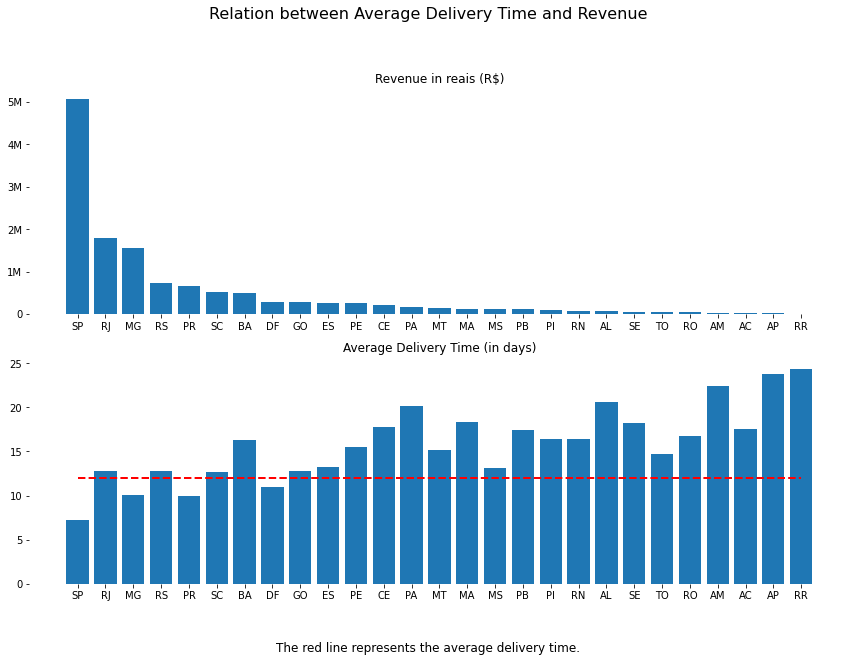

In [33]:
delivery = df.groupby('customer_state').agg({'price':'sum', 
                    'approved_to_customer': 'mean'}).sort_values(by=['price'],ascending=False)

plt.figure(figsize=(12,8))
plt.suptitle(f"Relation between Average Delivery Time and Revenue", y=1.05, fontsize=16)

plt.subplot(211)
plt.bar(delivery.index, delivery['price'])
plt.title('Revenue in reais (R$)')
plt.yticks([0,1e+6,2e+6,3e+6,4e+6,5e+6], labels=['0', '1M', '2M', '3M', '4M', '5M'])
plt.box(False)

plt.subplot(212)
plt.bar(delivery.index, delivery['approved_to_customer'])
plt.title('Average Delivery Time (in days)')
plt.yticks([0, 5e+14, 10e+14, 15e+14, 20e+14, 25e+14], labels=['0', '5', '10', '15', '20', '25'])
plt.hlines(y = 12e+14,xmin=0, xmax='RR', colors='red', linestyle='dashed', linewidth=2)

footnote = f"The red line represents the average delivery time."
fig_txt = tw.fill(tw.dedent(footnote.rstrip()), width=150)
plt.figtext(0.5, -0.07, fig_txt, horizontalalignment='center', fontsize=12, multialignment="left")

plt.tight_layout()
plt.box(False)
plt.show()

Looking to the graphs above, we can see that in the top revenue states, the delivery time is faster. Especially in Sao Paulo (SP)

***

### 6.2 Delivery Performance 

In [36]:
# Calculating de percentage of late deliveries
delivery = df

def no_prazo(days):
    if days > datetime.timedelta(0):
        return 'Delivered in time'
    elif days < datetime.timedelta(0):
        return 'Late delivery'
    else:
        return 'No delivery'

delivery['in_time'] = delivery['delivered_vs_estimated'].apply(lambda x: no_prazo(x))
delivery['count'] = 1

In [38]:
delivery_status = delivery.groupby('in_time').sum()

delivery_status['%'] = delivery_status['count']*100/len(delivery['count'])
delivery_status.head()

,price,count,%
in_time,,,
Delivered in time,11733887.08,98520,90.027688
Late delivery,1137394.41,8535,7.799293
No delivery,360174.38,2378,2.173019


In general, 90% of the deliveries were made in time, 7.80% were late and 2.17% of the deliveries were not delivered. 

***

### 6.3 Deliveries Performance by State

In [39]:
delivery_states = delivery.groupby(['customer_state', 'in_time']).sum()
delivery_states = delivery_states.pivot_table(index='customer_state', columns='in_time', values='count')

In [41]:
delivery_states['total'] = delivery_states['Late delivery'] + delivery_states['Delivered in time'] 
+ delivery_states['No delivery'] 

delivery_states['% late'] = delivery_states['Late delivery']*100/delivery_states['total']
delivery_states['% in time'] = delivery_states['Delivered in time']*100/delivery_states['total']
delivery_states['% no delivery'] = delivery_states['No delivery']*100/delivery_states['total']

delivery_states.head()

in_time,Delivered in time,Late delivery,No delivery,total,% late,% in time,% no delivery
customer_state,,,,,,,
AC,83,3,1,86,3.488372,96.511628,1.162791
AL,319,100,17,419,23.866348,76.133652,4.057279
AM,153,7,2,160,4.375000,95.625000,1.250000
AP,77,4,1,81,4.938272,95.061728,1.234568
BA,3082,493,114,3575,13.790210,86.209790,3.188811


***

### 6.4 Delivery Performance by Product Category

In [42]:
delivery_cat = delivery.groupby(['product_category_name_english', 'in_time']).sum()
delivery_cat = delivery_cat.pivot_table(index='product_category_name_english', columns='in_time', values='count')

delivery_cat['total'] = delivery_cat['Late delivery'] + delivery_cat['Delivered in time'] 
+ delivery_cat['No delivery'] 

delivery_cat['% late'] = delivery_cat['Late delivery']*100/delivery_cat['total']
delivery_cat['% in time'] = delivery_cat['Delivered in time']*100/delivery_cat['total']
delivery_cat['% no delivery'] = delivery_cat['No delivery']*100/delivery_cat['total']

delivery_cat.head()

in_time,Delivered in time,Late delivery,No delivery,total,% late,% in time,% no delivery
product_category_name_english,,,,,,,
agro_industry_and_commerce,195.0,9.0,6.0,204.0,4.411765,95.588235,2.941176
air_conditioning,274.0,11.0,8.0,285.0,3.859649,96.140351,2.807018
art,179.0,15.0,12.0,194.0,7.731959,92.268041,6.185567
arts_and_craftmanship,21.0,2.0,NaN,23.0,8.695652,91.304348,NaN
audio,312.0,46.0,2.0,358.0,12.849162,87.150838,0.558659


***


### 6.5 Steps of the delivery process

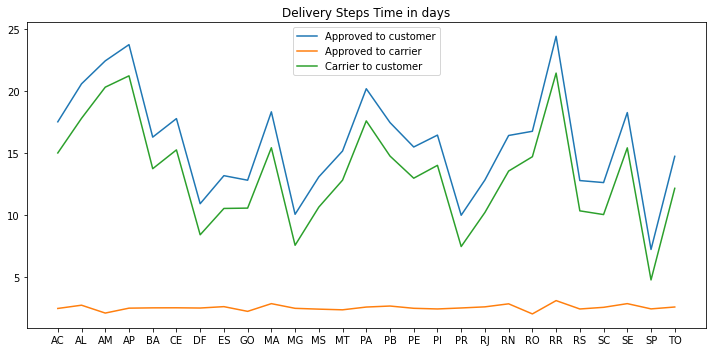

In [43]:
delivery = df.groupby('customer_state')[['approved_to_customer','approved_to_carrier',
                                        'carrier_to_customer','delivered_vs_estimated' ]].mean()
plt.figure(figsize=(10,5))

plt.title('Delivery Steps Time in days')
plt.yticks([0, 5e+14, 10e+14, 15e+14, 20e+14, 25e+14], labels=['0', '5', '10', '15', '20', '25'])

plt.plot(delivery.index, delivery.approved_to_customer, label= 'Approved to customer')
plt.plot(delivery.index, delivery.approved_to_carrier, label='Approved to carrier')
plt.plot(delivery.index, delivery.carrier_to_customer, label='Carrier to customer')

plt.legend()
plt.tight_layout()
plt.show()

With this graph we can note that the delivery time is not related with the time form order approved to order delivered to carrier (responsability of the seller). 



***